# Interpretable Modelling of Credit Risk

>*Rakeen Rouf*
>
>*Bárbara Flores*


As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, s, f, te
from sklearn.metrics import confusion_matrix
from mpl_toolkits import mplot3d

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [2]:
VariablesList = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "MATE_EDUCATION_LEVEL",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]

Modeling_Data = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt",
    sep="\t",
    header=None,
    names=VariablesList,
    index_col=None,
    encoding="latin8",
    low_memory=False,
)

Modeling_Data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [3]:
Modeling_Data.shape

(50000, 54)

> First, we validate which variables have more than 25,000 records encoded as null. We can observe in the following summary that the variables `PROFESSIONAL_CITY`, `PROFESSIONAL_BOROUGH`, `MATE_PROFESSION_CODE`, and `MATE_EDUCATION_LEVEL` meet this condition.

In [4]:
Modeling_Data.isnull().sum().sort_values(ascending=False).head(10)

PROFESSIONAL_CITY                 33783
PROFESSIONAL_BOROUGH              33783
MATE_EDUCATION_LEVEL              32338
MATE_PROFESSION_CODE              28884
PROFESSION_CODE                    7756
OCCUPATION_TYPE                    7313
MONTHS_IN_RESIDENCE                3777
RESIDENCE_TYPE                     1349
PROFESSIONAL_PHONE_AREA_CODE          0
QUANT_SPECIAL_BANKING_ACCOUNTS        0
dtype: int64

>Later, upon visual inspection of the database, we noticed that the variables `EDUCATION_LEVEL`, `APPLICATION_SUBMISSION_TYPE`, `PROFESSIONAL_STATE`, and `PROFESSIONAL_PHONE_AREA_CODE` also appear to be problematic, which we will validate next.

In [5]:
Modeling_Data.groupby("EDUCATION_LEVEL").size().sort_values(ascending=False)

EDUCATION_LEVEL
0    50000
dtype: int64

In [6]:
Modeling_Data.groupby("APPLICATION_SUBMISSION_TYPE").size().sort_values(ascending=False)

APPLICATION_SUBMISSION_TYPE
Web      28206
0        19461
Carga     2333
dtype: int64

In [7]:
Modeling_Data.groupby("PROFESSIONAL_PHONE_AREA_CODE").size().sort_values(
    ascending=False
).head(5)

PROFESSIONAL_PHONE_AREA_CODE
       36532
5       1457
54      1109
107      981
97       644
dtype: int64

In [8]:
Modeling_Data.groupby("PROFESSIONAL_STATE").size().sort_values(ascending=False).head(5)

PROFESSIONAL_STATE
      34307
SP     2400
RS     2092
CE     1420
BA     1387
dtype: int64

> Out of the 4 previously mentioned problematic variables, we observe that `PROFESSIONAL_STATE` and `PROFESSIONAL_PHONE_AREA_CODE` have more than 25,000 missing values. Additionally, `EDUCATION_LEVEL` presents the value 0 for all its data, while the encoding in the dictionary starts from 1. 
>
>Therefore, our final list of variables to be removed, which have more than half missing values, includes `EDUCATION_LEVEL`, `PROFESSIONAL_CITY`, `PROFESSIONAL_BOROUGH`, `MATE_PROFESSION_CODE`, `MATE_EDUCATION_LEVEL`, `PROFESSIONAL_STATE`, and `PROFESSIONAL_PHONE_AREA_CODE`.

In [9]:
columns_to_drop = [
    "EDUCATION_LEVEL",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "MATE_PROFESSION_CODE",
    "MATE_EDUCATION_LEVEL",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_PHONE_AREA_CODE",
]

Modeling_Data = Modeling_Data.drop(columns_to_drop, axis=1)

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [10]:
Modeling_Data = Modeling_Data[
    [
        "QUANT_DEPENDANTS",
        "QUANT_CARS",
        "MONTHS_IN_RESIDENCE",
        "PERSONAL_MONTHLY_INCOME",
        "QUANT_BANKING_ACCOUNTS",
        "AGE",
        "SEX",
        "MARITAL_STATUS",
        "OCCUPATION_TYPE",
        "RESIDENCE_TYPE",
        "RESIDENCIAL_STATE",
        "RESIDENCIAL_CITY",
        "RESIDENCIAL_BOROUGH",
        "RESIDENCIAL_ZIP_3",
        "TARGET_LABEL_BAD=1",
    ]
]

>First, given the wide range of values taken by the variable `PERSONAL_MONTHLY_INCOME` and the fact that the variance increases as the level of the variable grows, we transform this variable by taking the logarithm, resulting in the creation of the variable `LOG_PERSONAL_MONTHLY_INCOME`.

In [11]:
# PERSONAL_MONTHLY_INCOME
Modeling_Data["LOG_PERSONAL_MONTHLY_INCOME"] = np.log(
    Modeling_Data["PERSONAL_MONTHLY_INCOME"]
)

Modeling_Data.drop(columns=["PERSONAL_MONTHLY_INCOME"], inplace=True)

>Second, we can observe that in the variable `QUANT_DEPENDANTS`, there is an outlier with a value of 53. Since there is only 1 record with this value, we have no problem in removing it.

In [12]:
# QUANT_DEPENDANTS
Modeling_Data.groupby("QUANT_DEPENDANTS").size().sort_index()

QUANT_DEPENDANTS
0     33655
1      7004
2      5363
3      2465
4       860
5       365
6       139
7        65
8        35
9        14
10       13
11        7
12        6
13        4
14        3
15        1
53        1
dtype: int64

In [13]:
Modeling_Data = Modeling_Data[Modeling_Data["QUANT_DEPENDANTS"] != 53]

>After the transformations mentioned earlier, we can observe the distribution of our numerical variables in the following histograms.

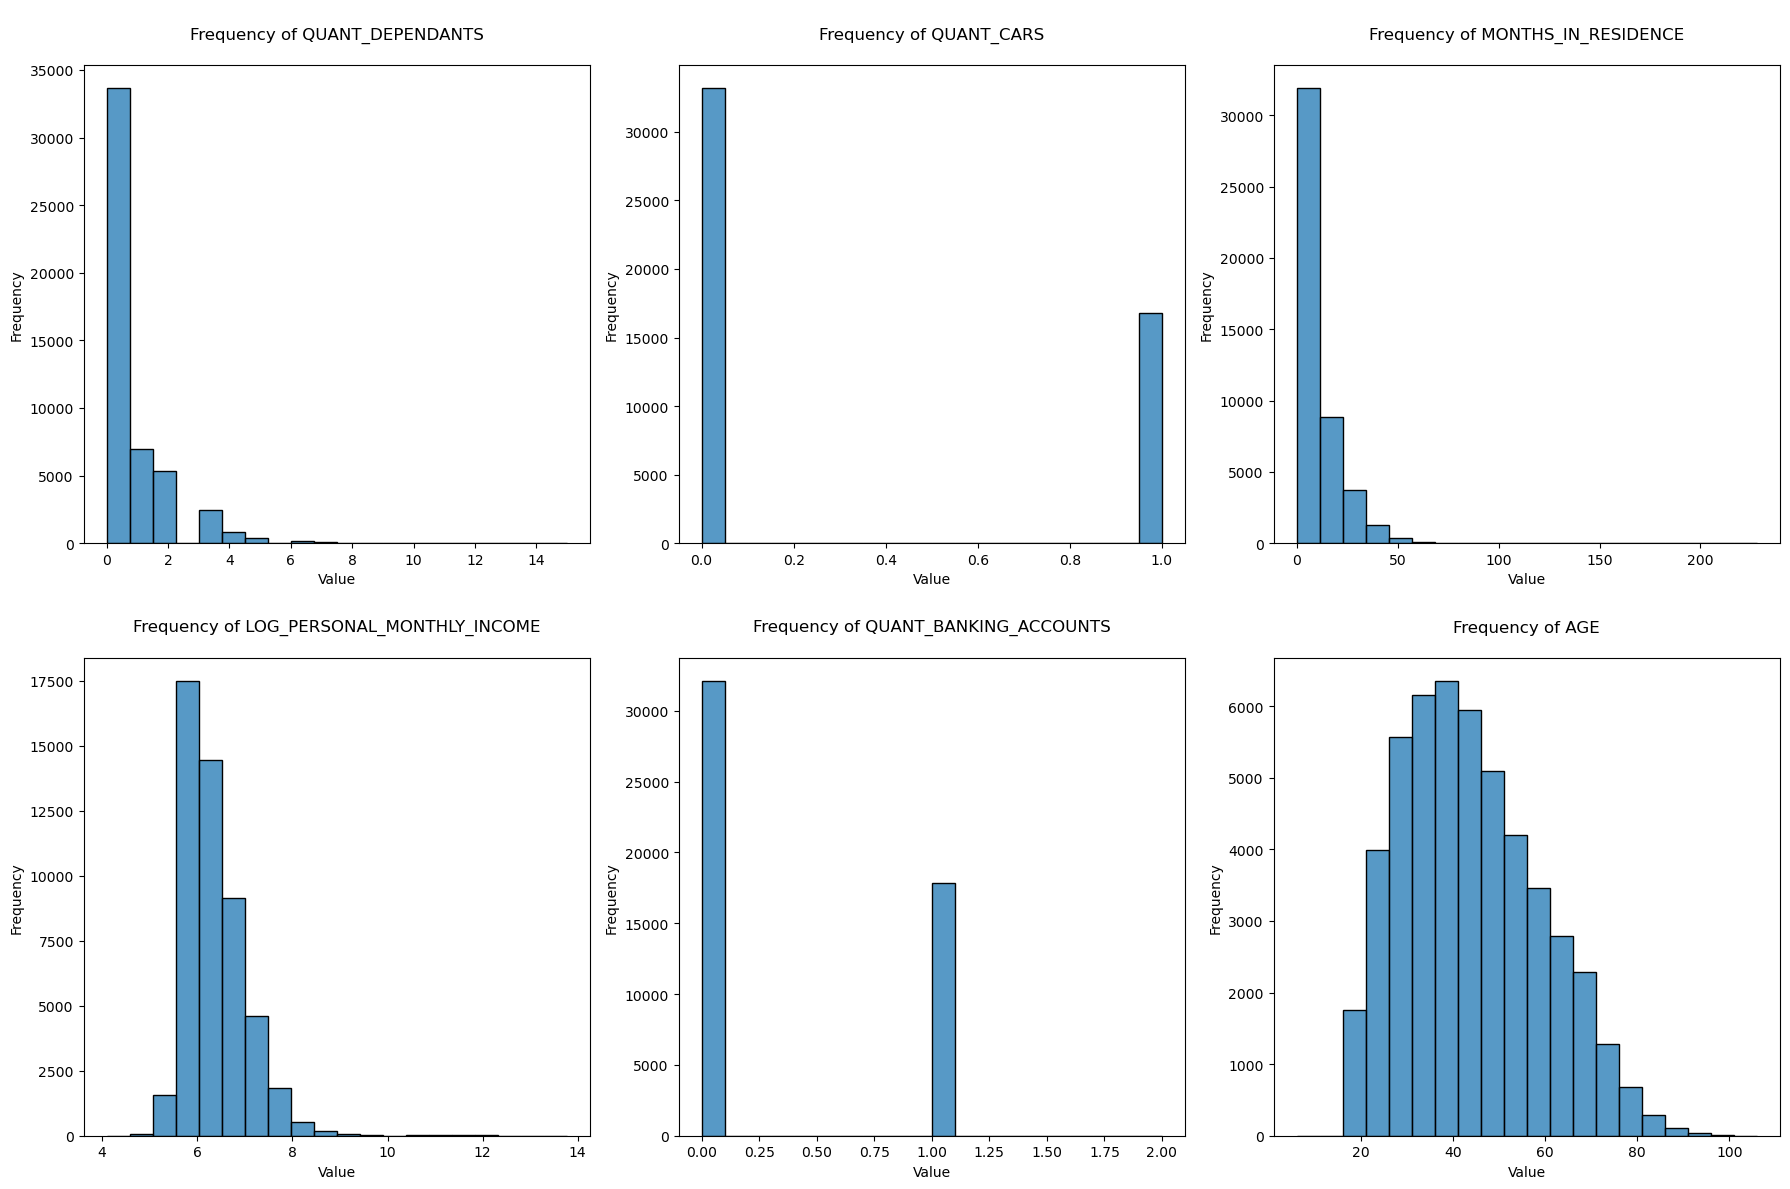

In [14]:
variables_num = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "LOG_PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
]

plt.figure(figsize=(18, 12))

for i, variable in enumerate(variables_num, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(data=Modeling_Data[variable], bins=20)
    plt.title(f"\nFrequency of {variable}\n")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

> Similarly, we can observe the distribution of our categorical variables in the following bar plots.
>
>It is worth mentioning that some of these variables may not be as useful in their interpretation, as we find that the variables `MARITAL_STATUS`, `OCCUPATION_TYPE`, and `RESIDENCE_TYPE` are labeled as "Encoding not informed" in our dictionary. While we may encounter a model that informs us whether these variables are important or not, we will not be able to determine their true contribution to the model due to the lack of information about their encoding.

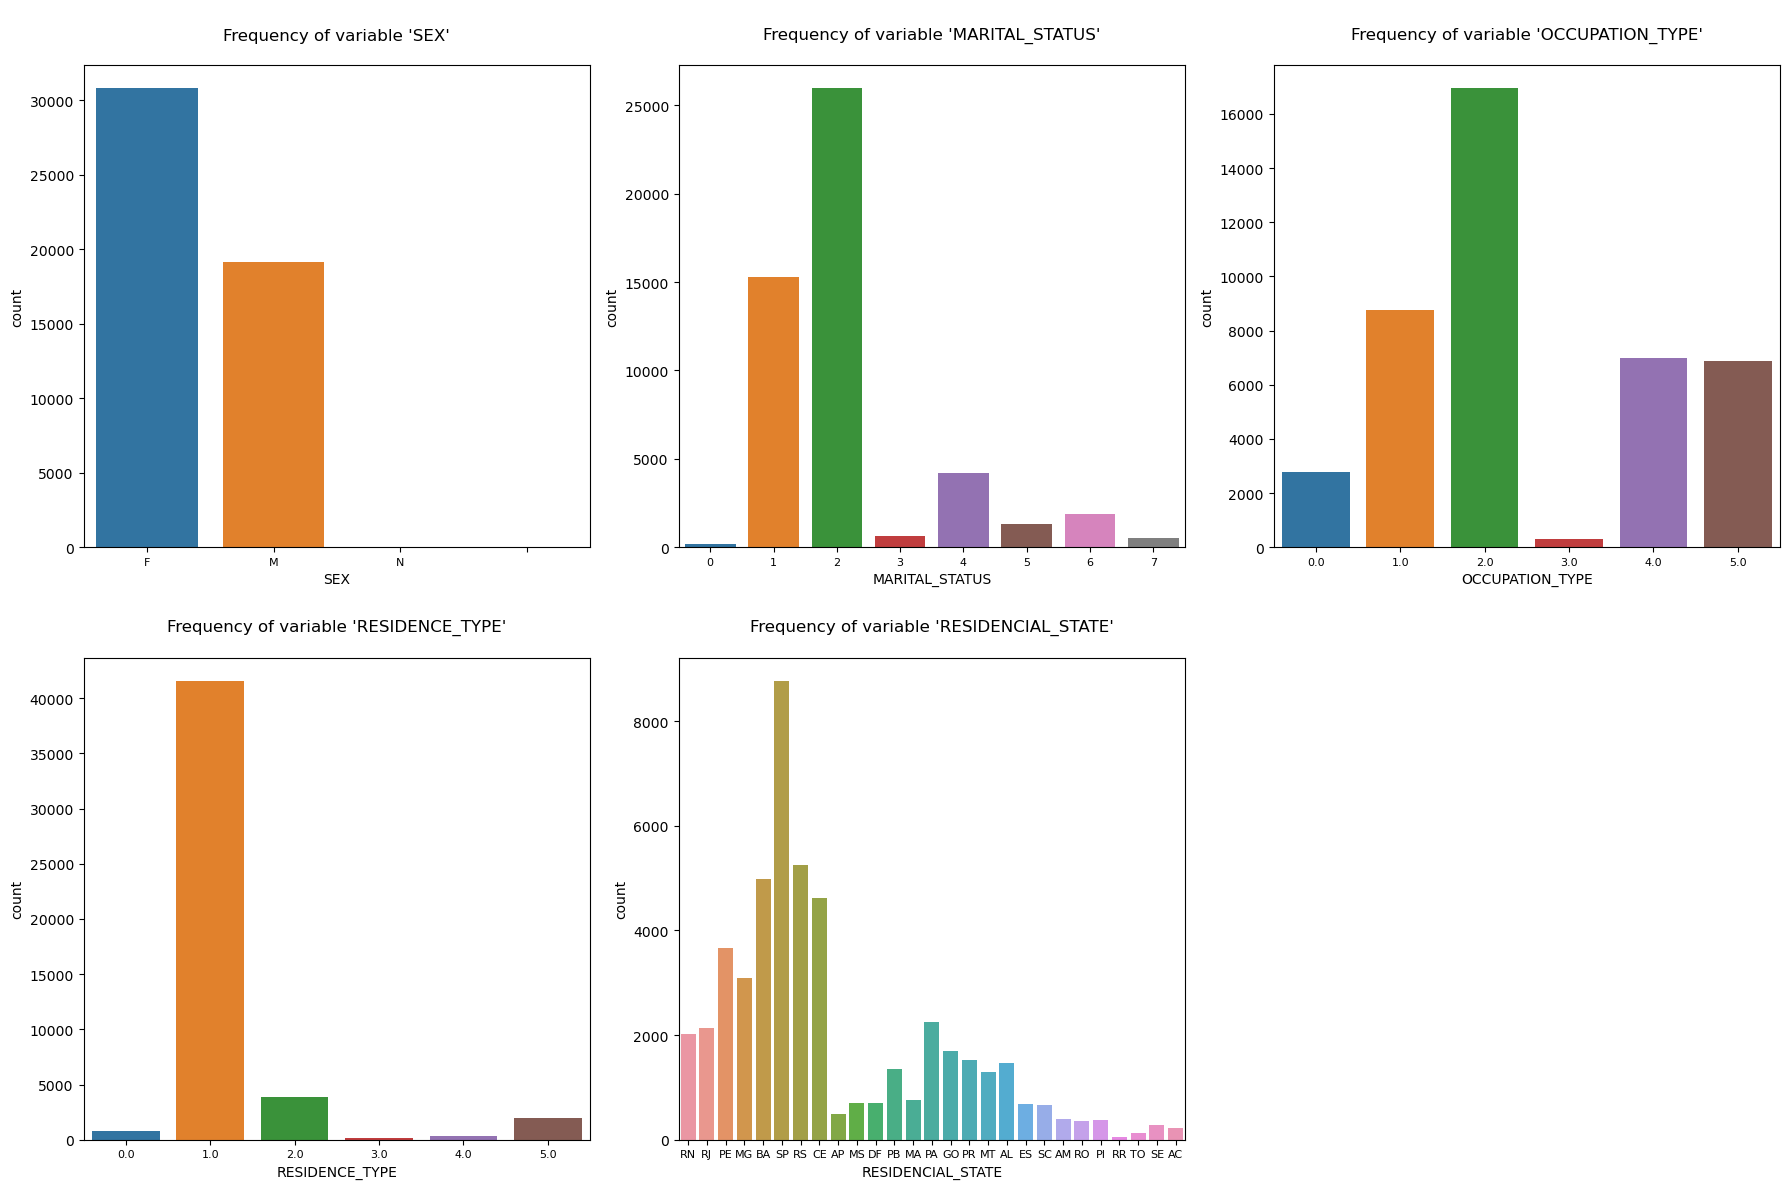

In [15]:
variables_cat = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
]

plt.figure(figsize=(18, 12))

for i, variable in enumerate(variables_cat, start=1):
    plt.subplot(2, 3, i)
    sns.countplot(data=Modeling_Data, x=variable)
    plt.title(f"\nFrequency of variable '{variables_cat[i - 1]}'\n")
    plt.xticks(fontsize=8)


plt.tight_layout()
plt.show()

> Aditionally, the categorical variables `RESIDENCIAL_CITY`, `RESIDENCIAL_BOROUGH`, and `RESIDENCIAL_ZIP_3` cannot be plotted because they have 3,529, 14,511, and 794 different unique categories respectively.

In [16]:
print(
    f"Number of unique categories in RESIDENCIAL_CITY: {Modeling_Data['RESIDENCIAL_CITY'].nunique():,}"
)
print(
    f"Number of unique categories in RESIDENCIAL_BOROUGH: {Modeling_Data['RESIDENCIAL_BOROUGH'].nunique():,}"
)
print(
    f"Number of unique categories in RESIDENCIAL_ZIP_3: {Modeling_Data['RESIDENCIAL_ZIP_3'].nunique():,}"
)

Number of unique categories in RESIDENCIAL_CITY: 3,529
Number of unique categories in RESIDENCIAL_BOROUGH: 14,511
Number of unique categories in RESIDENCIAL_ZIP_3: 794


> Finally, for the variables `SEX`, `MARITAL_STATUS`, `OCCUPATION_TYPE`, and `RESIDENCE_TYPE`, we encounter values that are not within the valid elements in our dictionary. For example, "N" in the case of `SEX` and 0 in the case of `MARITAL_STATUS`, `OCCUPATION_TYPE`, and `RESIDENCE_TYPE`. Therefore, we will transform these values to null.

In [17]:
Modeling_Data[Modeling_Data["SEX"] == "N"] = np.nan
Modeling_Data[Modeling_Data["SEX"] == " "] = np.nan
Modeling_Data[Modeling_Data["MARITAL_STATUS"] == 0] = np.nan
Modeling_Data[Modeling_Data["OCCUPATION_TYPE"] == 0] = np.nan
Modeling_Data[Modeling_Data["RESIDENCE_TYPE"] == 0] = np.nan

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

In [18]:
Modeling_Data["RESIDENCIAL_CITY"].value_counts().sort_values(ascending=False)

Sao Paulo               821
FORTALEZA               815
Fortaleza               682
MACEIO                  610
PELOTAS                 590
                       ... 
Curuca                    1
LAGOA DA CANOA            1
TANGARA DA SERRRA         1
Hidreletrica Tucurui      1
conselheiro lafaiete      1
Name: RESIDENCIAL_CITY, Length: 3396, dtype: int64

In [19]:
Modeling_Data["RESIDENCIAL_BOROUGH"].value_counts().sort_values(ascending=False)

CENTRO              3823
Centro               397
ZONA RURAL           351
centro               315
Fragata              226
                    ... 
PONTINHA CENTRO        1
CLIMA BOM 1            1
De Fatima              1
Vila Vitoria           1
jardim vida nova       1
Name: RESIDENCIAL_BOROUGH, Length: 13698, dtype: int64

> Added to the previously mentioned fact that we have many different categories for the same variable, we can see that in the case of `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`, we also encounter city names written in many different ways, which may include differences in capitalization, abbreviations, etc.
>
>Although we could address these differences with the purpose of achieving uniformity, for the purposes of this exercise, we will simply remove these variables.

In [20]:
Modeling_Data.drop(
    ["RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH", "RESIDENCIAL_STATE"],
    axis=1,
    inplace=True,
)

## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [21]:
one_hot_encoded = pd.get_dummies(Modeling_Data["SEX"], prefix="SEX", drop_first=True)
Modeling_Data = pd.concat([Modeling_Data, one_hot_encoded], axis=1)
Modeling_Data.drop("SEX", axis=1, inplace=True)

In [22]:
Modeling_Data.dropna(inplace=True)

X = Modeling_Data[
    [
        "QUANT_DEPENDANTS",
        "QUANT_CARS",
        "MONTHS_IN_RESIDENCE",
        "LOG_PERSONAL_MONTHLY_INCOME",
        "QUANT_BANKING_ACCOUNTS",
        "AGE",
        "SEX_M",
        "MARITAL_STATUS",
        "OCCUPATION_TYPE",
        "RESIDENCE_TYPE",
    ]
]

X = X.copy()

# recoding MARITAL_STATUS to include 0, to help with partial dependence plots
X.loc[:, "MARITAL_STATUS"] = X["MARITAL_STATUS"] - 1
# recoding Residence Type to include 0, to help with partial dependence plots
X.loc[:, "RESIDENCE_TYPE"] = X["RESIDENCE_TYPE"] - 1
# recoding Occupation Type to include 0, to help with partial dependence plots
X.loc[:, "OCCUPATION_TYPE"] = X["OCCUPATION_TYPE"] - 1

y = Modeling_Data[["TARGET_LABEL_BAD=1"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [23]:
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + f(7) + f(8) + f(9))
gam.gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:19
 18% (2 of 11) |####                     | Elapsed Time: 0:00:03 ETA:   0:00:16
 27% (3 of 11) |######                   | Elapsed Time: 0:00:05 ETA:   0:00:12
 36% (4 of 11) |#########                | Elapsed Time: 0:00:06 ETA:   0:00:11
 45% (5 of 11) |###########              | Elapsed Time: 0:00:08 ETA:   0:00:10
 54% (6 of 11) |#############            | Elapsed Time: 0:00:09 ETA:   0:00:07
 63% (7 of 11) |###############          | Elapsed Time: 0:00:11 ETA:   0:00:05
 72% (8 of 11) |##################       | Elapsed Time: 0:00:12 ETA:   0:00:03
 81% (9 of 11) |####################     | Elapsed Time: 0:00:13 ETA:   0:00:02
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:14 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + f(7) + f(8) + f(9) + intercept,
   tol=0.0001, verbose=False)

### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

> If we calculate our predictions in a "naive" manner, meaning without adjusting the predefined parameters of the model, we obtain these results:

In [24]:
y_pred = gam.predict(X_test.values)
conf_matrix = confusion_matrix(y_test.values, y_pred)
conf_matrix

array([[5516,    1],
       [1882,    1]])

In [25]:
true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
print(f"TN: {true_negative:,}")
print(f"FP: {false_positive:,}")
print(f"FN: {false_negative:,}")
print(f"TP: {true_positive:,}")

TN: 5,516
FP: 1
FN: 1,882
TP: 1


> With our confusion matrix information, we can deduce the following:
>
> - The total number of individuals to whom credit is extended would be TN + FN = `7,398`.
>- However, among these individuals to whom credit would be extended, it is expected that `1,882` would be false negatives. In other words, these are individuals identified as "safe bets" who actually default.
> - Therefore, the proportion of individuals identified as "safe bets" who actually default would be $\frac{FN}{TN + FN} = \frac{1,882}{7,398}$ = `0.254`.
> 
> - The "good bets" predicted by the model (true negatives) are `5,516`.
> - The False Omission Rate or the share of predicted negatives that are false negatives would be  $\frac{FN}{FN + TN} = \frac{1,882}{1,882 + 5,516}$ = `0.254`. 
>
>When looking at the confusion matrix, it appears that the model is prioritizing accuracy optimization by minimizing false positives, as evidenced by the low count of only 1 false positive. However, in this case, we are likely not employing the best strategy, as the model is allowing for a high number of false negatives.
>
>Minimizing false positives would result in minimizing the denial of credit to good payers. However, by tolerating a high number of false negatives, the model is allowing a large number of bad payers that are being mistakenly identified as good and are being approved.
>
>A more balanced strategy could involve adjusting the model's classification thresholds to allow for greater sensitivity in detecting bad payers, which would help reduce the number of false negatives without compromising too much on the accuracy of identifying good payers.

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

>Our objective is to determine a threshold that maximizes False Negative Rates while ensuring that the number of True negatives exceeds 10.
>
>We proceed to compute our metrics for 100 different thresholds ranging from 0 to 1. The metrics we will take into consideration are those that our stakeholder is interested in, namely TN, FNR, and FOR.
>
>We have the following formulas:
>
>$FNR = \frac{FN}{FN + TP}$
>
>$FOR = \frac{FN}{FN + TN}$

In [26]:
y_pred_proba = gam.predict_proba(X_test.values)
thresholds = np.linspace(0, 1, 100)

FNR_list = []
FOR_list = []
TN_list = []
thresholds_list = []


for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    conf_matrix = confusion_matrix(y_test.values, y_pred)
    true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()

    with np.errstate(divide="ignore", invalid="ignore"):
        FNR = false_negative / (false_negative + true_positive)
        FOR = false_negative / (false_negative + true_negative)

    # We will only save in the list the values that meet our constraint of TN > 10.
    if true_negative > 10:
        FNR_list.append(FNR)
        FOR_list.append(FOR)
        TN_list.append(true_negative)
        thresholds_list.append(threshold)

>Then we proceed to graph these variables for different thresholds, with the objective of finding an optimum according to our stakeholder's requirements

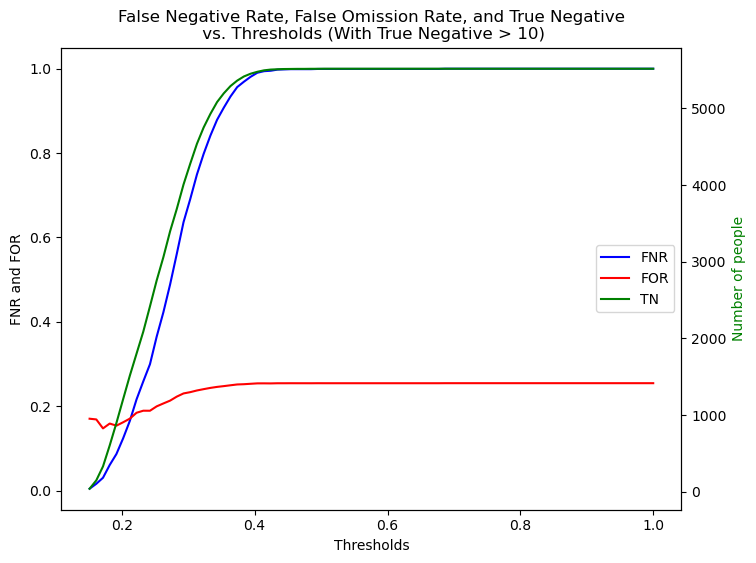

In [27]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(thresholds_list, FNR_list, label="FNR", color="blue")
ax1.plot(thresholds_list, FOR_list, label="FOR", color="red")
ax1.set_xlabel("Thresholds")
ax1.set_ylabel("FNR and FOR", color="black")

ax2 = ax1.twinx()
ax2.plot(thresholds_list, TN_list, label="TN", color="green")
ax2.set_ylabel("Number of people", color="green")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title(
    "False Negative Rate, False Omission Rate, and True Negative\n vs. Thresholds (With True Negative > 10)"
)
plt.show()

> The previous graph was built using the results of our model for different thresholds, with the constraint of having a total of true negatives greater than 10. 
>
> As the threshold increases, we notice a simultaneous increase in our False Negative Rate, which eventually reaches 100%, and in our true negatives, which also increase until they cover 100% of the non-risky individuals in the dataset, approximately 55,000. The False Omission Rate grows until stabilizing at 0.25.
>
>Our lowest False Negative Rate occurs with a threshold of approximately `0.15`, resulting in:
>
>False Negative Rate: 0.00212
>
>False Omission Rate: 0.11429
>
>True Negatives = 31 > 10.
>
>However, this model predicts a very small number of true negatives, specifically, 31 customers who would be eligible for a loan according to our stakeholder's criteria and who indeed turn out to be good customers. 
>
> While we meet the constraints specified in the problem statement, the restricted number of eligible customers might not generate profitability for the stakeholder.

In [28]:
y_pred = (y_pred_proba > 0.15).astype(int)
conf_matrix = confusion_matrix(y_test.values, y_pred)

true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
print(f"TN: {true_negative:,}")
print(f"FP: {false_positive:,}")
print(f"FN: {false_negative:,}")
print(f"TP: {true_positive:,}")
print()

FNR = false_negative / (false_negative + true_positive)
FOR = false_negative / (false_negative + true_negative)
print("False Negative Rate:", round(FNR, 5))
print("False Omission Rate:", round(FOR, 5))

TN: 31
FP: 5,486
FN: 4
TP: 1,879

False Negative Rate: 0.00212
False Omission Rate: 0.11429


### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

> We will use the same strategy as in the previous exercise. We will calculate our relevant metrics for different threshold values, considering the restriction that the false omission rate should be less than 19%.

In [29]:
FNR_list = []
FOR_list = []
TN_list = []
thresholds_list = []


for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    conf_matrix = confusion_matrix(y_test.values, y_pred)
    true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()

    with np.errstate(divide="ignore", invalid="ignore"):
        FNR = false_negative / (false_negative + true_positive)
        FOR = false_negative / (false_negative + true_negative)

    # We will only save in the list the values that meet our constraint of false omission rate <= 19%,.
    if FOR <= 0.19:
        FNR_list.append(FNR)
        FOR_list.append(FOR)
        TN_list.append(true_negative)
        thresholds_list.append(threshold)

> Then we proceed to graph how these values behave for different threshold values.

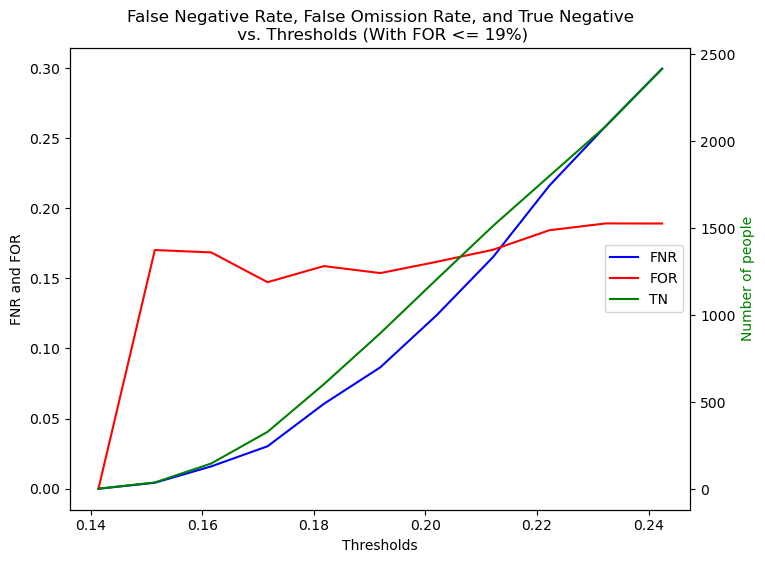

In [30]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(thresholds_list, FNR_list, label="FNR", color="blue")
ax1.plot(thresholds_list, FOR_list, label="FOR", color="red")
ax1.set_xlabel("Thresholds")
ax1.set_ylabel("FNR and FOR", color="black")

ax2 = ax1.twinx()
ax2.plot(thresholds_list, TN_list, label="TN", color="green")
ax2.set_ylabel("Number of people", color="green")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title(
    "False Negative Rate, False Omission Rate, and True Negative\n vs. Thresholds (With FOR <= 19%)"
)
plt.show()

> We can see in the previous graph that our maximum value of true negatives, considering our restriction, is achieved for a threshold of around 0.24. For this threshold, our maximum value of true negatives is 2,334.
>
> It's worth mentioning that the tradeoff in this situation compared to the previous case is that we increase our False Negatives, and consequently our False Negative Rate and False Omission Rate

In [31]:
y_pred = (y_pred_proba > 0.24).astype(int)
conf_matrix = confusion_matrix(y_test.values, y_pred)

true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
print(f"TN: {true_negative:,}")
print(f"FP: {false_positive:,}")
print(f"FN: {false_negative:,}")
print(f"TP: {true_positive:,}")
print()

FNR = false_negative / (false_negative + true_positive)
FOR = false_negative / (false_negative + true_negative)
print("False Negative Rate:", round(FNR, 5))
print("False Omission Rate:", round(FOR, 5))

TN: 2,334
FP: 3,183
FN: 544
TP: 1,339

False Negative Rate: 0.2889
False Omission Rate: 0.18902


## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

In [32]:
# lets look at the model summary to find the three significant continuous variables
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     24.8151
Link Function:                        LogitLink Log Likelihood:                                 -16684.882
Number of Samples:                        29598 AIC:                                            33419.3942
                                                AICc:                                            33419.441
                                                UBRE:                                               3.1298
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0178
Feature Function                  Lam

/var/folders/9m/ym86jvl93wq3tx6ssy8ql7kh0000gn/T/ipykernel_42174/697632557.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


<Figure size 640x480 with 0 Axes>

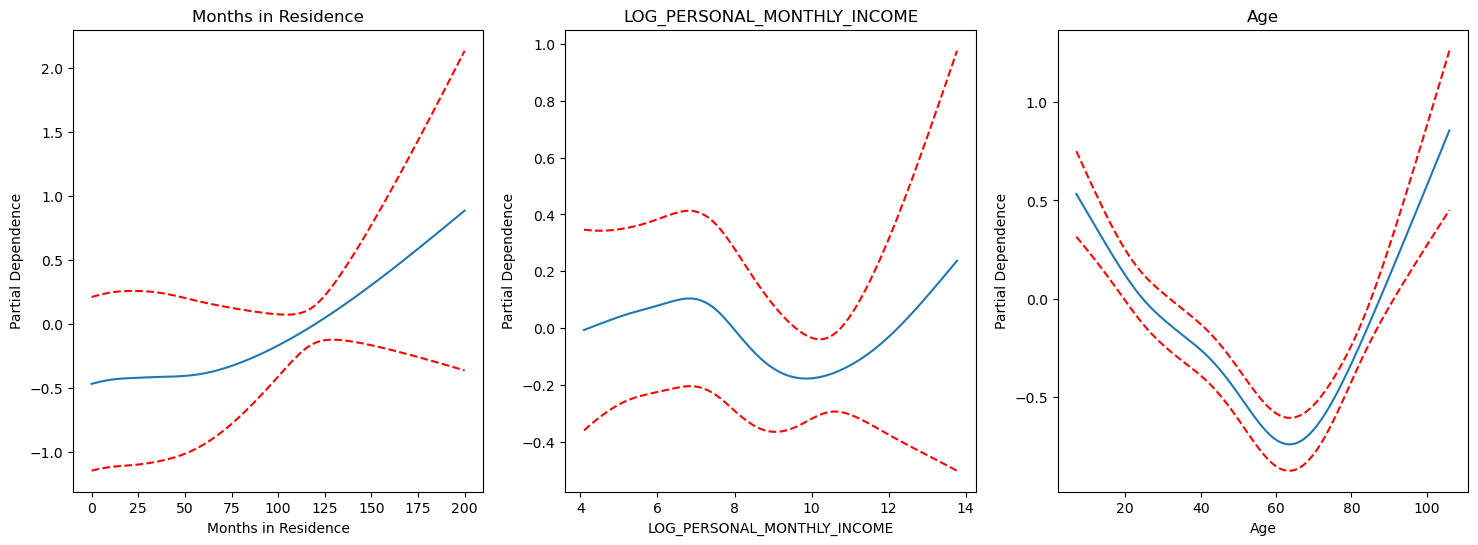

In [33]:
important_features = [2, 3, 5]

# Plotting the partial dependence plots
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Months in Residence", "LOG_PERSONAL_MONTHLY_INCOME", "Age"]
for i, ax in enumerate(axs):
    title = titles[i]
    i = important_features[i]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(
        XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c="r", ls="--"
    )
    # adding x and y labels
    ax.set_xlabel(title)
    ax.set_ylabel("Partial Dependence")
    ax.set_title(title)

plt.show()

### Exercise 10

How does the partial correlation with respect to age look?

> With respect to age, it looks like as age increases, initially that leads to less Bad Loans per unit increase in age (signified by the negative gradient). But as age increases beyond ~65, that leads to more Bad loans as age increases (signified by positive gradient). Therefore, there seems to be two zones of correlation, one positve, one negative. Overall, "age" looks to have a non-linear relationship with "Bad_Loan", with the weakest correlation atound 65 yers of age.

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

> Considering the partial correlation observed with respect to age in the previous graph, we believe that `the relationship between age and credit risk that makes the most sense to us is a convex relationship`. Therefore, we impose this convexity constraint and refit the model below.

In [34]:
gam = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(3)
    + s(4)
    + s(5, constraints="convex")  # convex constraint
    + f(6)
    + f(7)
    + f(8)
    + f(9)
)
gam.gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:34
 18% (2 of 11) |####                     | Elapsed Time: 0:00:05 ETA:   0:00:18
 27% (3 of 11) |######                   | Elapsed Time: 0:00:07 ETA:   0:00:14
 36% (4 of 11) |#########                | Elapsed Time: 0:00:08 ETA:   0:00:11
 45% (5 of 11) |###########              | Elapsed Time: 0:00:10 ETA:   0:00:09
 54% (6 of 11) |#############            | Elapsed Time: 0:00:11 ETA:   0:00:07
 63% (7 of 11) |###############          | Elapsed Time: 0:00:13 ETA:   0:00:05
 72% (8 of 11) |##################       | Elapsed Time: 0:00:14 ETA:   0:00:04
 81% (9 of 11) |####################     | Elapsed Time: 0:00:15 ETA:   0:00:02
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:17 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + f(7) + f(8) + f(9) + intercept,
   tol=0.0001, verbose=False)

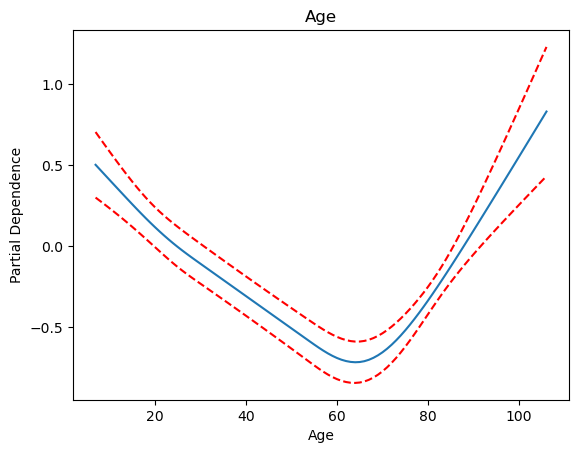

In [35]:
important_features = [2, 3, 5]

# Plotting the partial dependence plots
plt.figure()
title = "Age"
i = 5
XX = gam.generate_X_grid(term=i)
plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c="r", ls="--")
plt.title(title)
# adding x and y labels
plt.xlabel("Age")
plt.ylabel("Partial Dependence")
plt.show()

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

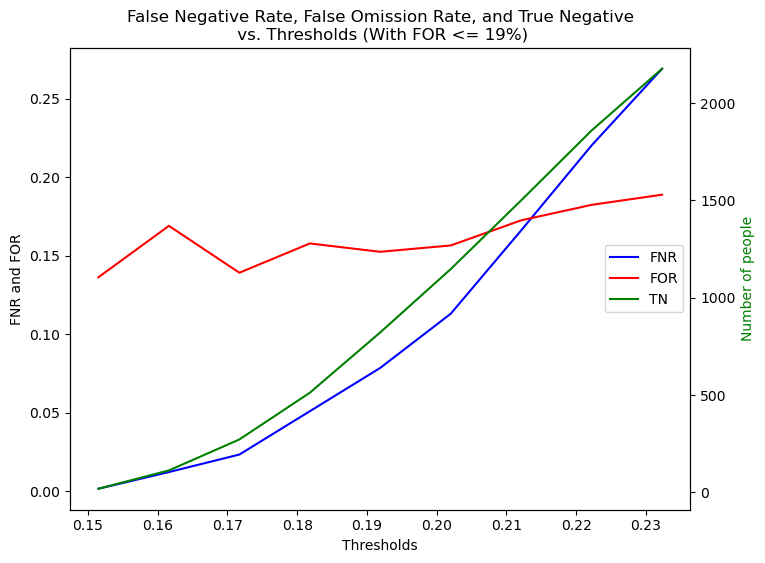

In [36]:
y_pred_proba = gam.predict_proba(X_test.values)

FNR_list = []
FOR_list = []
TN_list = []
thresholds_list = []


for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    conf_matrix = confusion_matrix(y_test.values, y_pred)
    true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()

    with np.errstate(divide="ignore", invalid="ignore"):
        FNR = false_negative / (false_negative + true_positive)
        FOR = false_negative / (false_negative + true_negative)

    # We will only save in the list the values that meet our constraint of false omission rate <= 19%,.
    if FOR <= 0.19:
        FNR_list.append(FNR)
        FOR_list.append(FOR)
        TN_list.append(true_negative)
        thresholds_list.append(threshold)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(thresholds_list, FNR_list, label="FNR", color="blue")
ax1.plot(thresholds_list, FOR_list, label="FOR", color="red")
ax1.set_xlabel("Thresholds")
ax1.set_ylabel("FNR and FOR", color="black")

ax2 = ax1.twinx()
ax2.plot(thresholds_list, TN_list, label="TN", color="green")
ax2.set_ylabel("Number of people", color="green")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title(
    "False Negative Rate, False Omission Rate, and True Negative\n vs. Thresholds (With FOR <= 19%)"
)
plt.show()

In [37]:
y_pred = (y_pred_proba > 0.23).astype(int)
conf_matrix = confusion_matrix(y_test.values, y_pred)

true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
print(f"TN: {true_negative:,}")
print(f"FP: {false_positive:,}")
print(f"FN: {false_negative:,}")
print(f"TP: {true_positive:,}")
print()

FNR = false_negative / (false_negative + true_positive)
FOR = false_negative / (false_negative + true_negative)
print("False Negative Rate:", round(FNR, 5))
print("False Omission Rate:", round(FOR, 5))

TN: 2,089
FP: 3,428
FN: 485
TP: 1,398

False Negative Rate: 0.25757
False Omission Rate: 0.18842


> We can see in the previous graph that our maximum value of true negatives, considering our restriction, is achieved for a threshold of around 0.23. For this threshold, our maximum value of true negatives is 2,089, which is less than the one from the previous implementation of the model without the monotonicity constraints (2,334). 

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

In [38]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     23.3484
Link Function:                        LogitLink Log Likelihood:                                -16688.3534
Number of Samples:                        29598 AIC:                                            33423.4036
                                                AICc:                                           33423.4453
                                                UBRE:                                               3.1299
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0176
Feature Function                  Lam

/var/folders/9m/ym86jvl93wq3tx6ssy8ql7kh0000gn/T/ipykernel_42174/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [39]:
lams = np.random.rand(100, 10)
lams = lams * 6 - 3  # shift values to -3, 3
lams = 10**lams  # transforms values to 1e-3, 1e3

gam = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(3)
    + s(4)
    + s(5, constraints="convex")  # convex constraint
    + f(6)
    + f(7)
    + f(8)
    + f(9)
)
gam.gridsearch(X_train.values, y_train.values, lam=lams)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:03:22
  2% (2 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:03:23
  3% (3 of 100) |                        | Elapsed Time: 0:00:05 ETA:   0:02:49
  4% (4 of 100) |                        | Elapsed Time: 0:00:07 ETA:   0:02:21
  5% (5 of 100) |#                       | Elapsed Time: 0:00:10 ETA:   0:04:43
  6% (6 of 100) |#                       | Elapsed Time: 0:00:12 ETA:   0:03:55
  7% (7 of 100) |#                       | Elapsed Time: 0:00:15 ETA:   0:03:58
  8% (8 of 100) |#                       | Elapsed Time: 0:00:16 ETA:   0:03:02
  9% (9 of 100) |##                      | Elapsed Time: 0:00:18 ETA:   0:03:19
 10% (10 of 100) |##                     | Elapsed Time: 0:00:20 ETA:   0:02:48
 11% (11 of 100) |##                     | Elapsed Time: 0:00:22 ETA:   0:02:28
 12% (12 of 100) |##                    

In [ ]:
gam.summary()

>In the above summary table, we can clearly notice how the grid search arrived at a different lambda value for ewach feature. This is likely to help against overfitting.

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

In [ ]:
y_pred_proba = gam.predict_proba(X_test.values)

FNR_list = []
FOR_list = []
TN_list = []
thresholds_list = []


for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    conf_matrix = confusion_matrix(y_test.values, y_pred)
    true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()

    with np.errstate(divide="ignore", invalid="ignore"):
        FNR = false_negative / (false_negative + true_positive)
        FOR = false_negative / (false_negative + true_negative)

    # We will only save in the list the values that meet our constraint of false omission rate <= 19%,.
    if FOR <= 0.19:
        FNR_list.append(FNR)
        FOR_list.append(FOR)
        TN_list.append(true_negative)
        thresholds_list.append(threshold)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(thresholds_list, FNR_list, label="FNR", color="blue")
ax1.plot(thresholds_list, FOR_list, label="FOR", color="red")
ax1.set_xlabel("Thresholds")
ax1.set_ylabel("FNR and FOR", color="black")

ax2 = ax1.twinx()
ax2.plot(thresholds_list, TN_list, label="TN", color="green")
ax2.set_ylabel("Number of people", color="green")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title(
    "False Negative Rate, False Omission Rate, and True Negative\n vs. Thresholds (With FOR <= 19%)"
)
plt.show()

In [ ]:
y_pred = (y_pred_proba > 0.23).astype(int)
conf_matrix = confusion_matrix(y_test.values, y_pred)

true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
print(f"TN: {true_negative:,}")
print(f"FP: {false_positive:,}")
print(f"FN: {false_negative:,}")
print(f"TP: {true_positive:,}")
print()

FNR = false_negative / (false_negative + true_positive)
FOR = false_negative / (false_negative + true_negative)
print("False Negative Rate:", round(FNR, 5))
print("False Omission Rate:", round(FOR, 5))

> We can see in the previous graph that our maximum value of true negatives, considering our restriction, is achieved for a threshold of around 0.23. For this threshold, our maximum value of true negatives is 2,104. Which is  slightly more than the model without the custom LAMS.

### Exercise 15
Add an interaction term between age and personal income.

In [ ]:
lams = np.random.rand(100, 10)
lams = lams * 6 - 3  # shift values to -3, 3
lams = 10**lams  # transforms values to 1e-3, 1e3

gam = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(4)
    + te(5, 3, constraints="convex")  # convex constraint
    + f(6)
    + f(7)
    + f(8)
    + f(9)
)
gam.gridsearch(X_train.values, y_train.values, lam=lams)

# lets look at our models summary
gam.summary()

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)
XX = gam.generate_X_grid(term=10, meshgrid=True)
Z = gam.partial_dependence(term=4, X=XX, meshgrid=True)

ax = plt.axes(projection="3d")
ax.plot_surface(XX[0], XX[1], Z, cmap="viridis")

ax.set_xlabel("AGE")
ax.set_ylabel("LOG_PERSONAL_MONTHLY_INCOME")
ax.set_zlabel("Partial Dependence")
plt.show()

> The 3D graph above shows that the relationship between age, income, and credit risk is complex and is best understood in the context of how these variables affect each other. In general, we can see that, on the one hand, credit risk tends to decrease as LOG_PERSONAL_MONTHLY_INCOME increases. However, the relationship between credit risk and age is convex. At younger ages, credit risk decreases with age, but after reaching the age of 60, credit risk tends to increase with each additional year

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ebm_global = ebm.explain_global()
    show(ebm_global)

    ebm_local = ebm.explain_local(X_train, y_train)
    show(ebm_local)

>From the first figure, we can confirm that AGE is a very important factor in credit default. Overall, we can see the importance of demographic and financial features in credit risk assesent. The model appeaks to capture both individual and interactive effects of the features. 